# Basic classification models

* objectives:
  * fit several base models including: 
  * `logistic regression`, `decision tree`, `svm`, `random forest`, `gradient boosting`, `knn`, `naive bayes`, `neural networks`
  * use aggregate feature for modelling
  
* plan: 

1. libraries and functions
2. load data
3. preprocess data
   - [x] full days only
   - [x] normalise activity
   - [ ] resample (not done)
4. feature engineering
   - [x] `mean`, `std`, `min`, `max`, `sum`
   - [x] `active_periods`, `inactive_periods`
5. train/test split
6. modelling
   - [x] import libraries
   - [x] model selection
   - [x] model evaluation
7. interpretation / visualisation
   



## Import libraries and load functions

In [1]:
# import
import pandas as pd
from sklearn.preprocessing import StandardScaler

### functions
- [x] extract depresjon from folder
- [x] extract full days (1440 rows) records and minimum full records
- [ ] resample, e.g. to hourly
- [x] normalise data (mean = 0, std = 1)
- [ ] 

In [2]:
# load pl functions

%run ../code/pl-functions.py

## Extract data from folder

In [3]:
# load the data
df = extract_folder('../data/depresjon')

## Data preprocessing

### Extract full days only


In [4]:
# extract full days
df7 = extract_full_days(df, 7)

In [5]:
# print rows per id / 1440
#print(df7.groupby('id').size()/1440)

# print unique count of id
print(df7['id'].nunique())

# print days for each id
#num_days = df.groupby('id')['date'].nunique()
#print(num_days)

# print date range for condition_1 id
print(df7[df7['id'] == 'condition_1']['date'].min())
print(df7[df7['id'] == 'condition_1']['date'].max())

# print info
#print(df7.info())



55
2003-05-08
2003-05-23


### Resample - 

* I am skipping this optional step for now...I want to see if it runs on the complete df

### Normalise

In [6]:
# column to normalise
col_to_normlise = ['activity']

# normalise
df7_norm = normalise_data(df7, col_to_normlise)


C:\Users\zoona\OneDrive - UWE Bristol\DS Year 2\IGP-5\code\pl-functions.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[columns_to_normalise] = scaler.fit_transform(df[columns_to_normalise])


## Feature engineering

This model will be run on aggregated features:

* `mean`, `std`, `min`, `max`, `sum`
* `active_periods`, `inactive_periods`

#### Active - what is active?

* trying to understand what could constitute being active in this data - will need more reading (actigraphs, etc.)
* going to start with 0.5 as the threshold

In [7]:
# summary stats for activity (normalised)
print(df7_norm['activity'].describe())

count    1.527281e+06
mean     2.452713e-17
std      1.000000e+00
min     -4.993880e-01
25%     -4.993880e-01
50%     -4.882190e-01
75%      6.185239e-02
max      2.183854e+01
Name: activity, dtype: float64


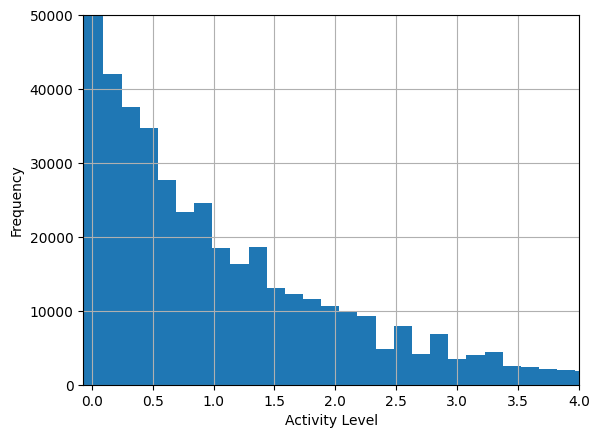

In [8]:
# plot activity histogram, zoom in on -0.07 to 0.07
import matplotlib.pyplot as plt
df7_norm['activity'].hist(bins=150)
plt.xlabel('Activity Level')
plt.ylabel('Frequency')
plt.xlim(-0.07, 4)  #  limits of the x-axis
plt.ylim(0, 50000)
plt.show()




In [9]:
def generate_features(df, activity_threshold=0.5):
    """
    Generate features for each subject in the DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame containing timestamp, date, activity, id, and label columns.
    activity_threshold (float): The threshold to define active vs inactive periods.

    Returns:
    DataFrame: A DataFrame where each row corresponds to a subject and contains the generated features.
    """
    # Group the DataFrame by 'id' and 'date'
    groups = df.groupby(['id', 'date'])

    # Calculate basic statistics
    mean_activity = groups['activity'].mean()
    std_activity = groups['activity'].std()
    min_activity = groups['activity'].min()
    max_activity = groups['activity'].max()
    total_activity = groups['activity'].sum()

    # Calculate number of active and inactive periods
    active_periods = groups.apply(lambda x: (x['activity'] > activity_threshold).sum())
    inactive_periods = groups.apply(lambda x: (x['activity'] <= activity_threshold).sum())

    # Combine all features into a single DataFrame
    features = pd.concat([mean_activity, std_activity, min_activity, max_activity, total_activity, active_periods, inactive_periods], axis=1)
    features.columns = ['mean_activity', 'std_activity', 'min_activity', 'max_activity', 'total_activity', 'active_periods', 'inactive_periods']

    # Reset the index
    features.reset_index(inplace=True)

    # Get the label for each subject
    labels = df.groupby('id')['label'].first()
    features = features.merge(labels, left_on='id', right_index=True)

    return features


In [10]:
# Generate features for df7_norm
df7_feat = generate_features(df7_norm, activity_threshold=0.5)

In [64]:
# print head
print(df7_feat.head())


            id        date  mean_activity  std_activity  min_activity  \
0  condition_1  2003-05-08      -0.063108      0.639730     -0.499388   
1  condition_1  2003-05-09      -0.152772      0.589836     -0.499388   
2  condition_1  2003-05-10      -0.122542      0.644881     -0.499388   
3  condition_1  2003-05-11      -0.221729      0.496237     -0.499388   
4  condition_1  2003-05-12       0.385401      1.385467     -0.499388   

   max_activity  total_activity  active_periods  inactive_periods  label  
0      4.956650      -90.875703             238              1202      1  
1      4.169238     -219.991698             179              1261      1  
2      5.492760     -176.460668             174              1266      1  
3      5.308472     -319.289356             124              1316      1  
4      9.346052      554.977909             435              1005      1  


## Train / Test split

In [11]:
from sklearn.model_selection import train_test_split

"""
Split the dataset into training and testing sets.

Parameters:
    X (DataFrame): The input features.
    y (Series): The target variable.
    test_size (float): The proportion of the dataset to include in the test split.
    random_state (int): The seed used by the random number generator.

Returns:
    X_train (DataFrame): The training set of input features.
    X_test (DataFrame): The testing set of input features.
    y_train (Series): The training set of target variable.
    y_test (Series): The testing set of target variable.
"""
X = df7_feat.drop(['label', 'date', 'id'], axis=1)
y = df7_feat['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Models

**Logistic Regression:**
LR is a statistical model used in binary classification by modelling the log-odds of the probability of an event.
* Strengths: Simple, fast, and efficient for small dataset with limited features.
* Weaknesses: Assumes a linear decision boundary, can underperform with complex datasets.

**Random Forest:**
* RF is an ensemble learning method constructs multiple decision trees at training time and outputting the class that is the mode of the classes of the individual trees.
* Strengths: Handles categorical variables well, resistant to overfitting, can model non-linear decision boundaries.
* Weaknesses: *Can be slow on large datasets*, not easily interpretable.

**Support Vector Machine (SVM):**
* SVM is a powerful and flexible class of supervised algorithms for both classification and regression.
* Strengths: Effective in high dimensional spaces, or when number of dimensions is greater than the number of samples.
* Weaknesses: Does not directly provide probability estimates, can be *inefficient to train*.
  
**Decision Tree:**
* DT are a type of simple flowchart-like structure in which internal node represents feature(or attribute), the branch represents a decision rule, and each leaf node represents the outcome.
* Strengths: Simple to understand and interpret, requires little data preparation.
* Weaknesses: Prone to overfitting, can create biased trees if some classes dominate.

**K-Nearest Neighbors (KNN):**
* KNN is a type of *instance-based learning, or lazy learning*, where the function is only approximated locally and all computation is deferred until function evaluation.
* Strengths: Simple, effective for datasets with complex decision boundaries.
* Weaknesses: *Slow on large datasets*, sensitive to irrelevant features.

**Naive Bayes:**
* NB classifiers are a family of simple “probabilistic classifiers” based on applying Bayes’ theorem with strong (naïve) independence assumptions between the features.
* Strengths: Fast, simple, performs well with small datasets.
* Weaknesses: *Assumes that all features are independent*, which is rarely the case.

**Neural Network (MLPClassifier):**
* MLPClassifier stands for Multi-layer Perceptron classifier connects to a Neural Network. MLPClassifier relies on an underlying Neural Network to perform the task of classification.
* Strengths: Can model complex, non-linear patterns.
* Weaknesses: *Requires a lot of data and computational resources, not easily interpretable.*

**XGBoost**:
* XGBoost is an optimised distributed gradient boosting library designed to be highly efficient, flexible and portable.
* Strengths: Fast, accurate, supports regularisation to avoid overfitting.
* Weaknesses: *Can be slow to train*, not easily interpretable.

**LightGBM**:
* LightGBM is a gradient boosting framework that uses tree-based learning algorithms. It is designed to be distributed and efficient with the following advantages: Faster training speed and higher efficiency, lower memory usage, better accuracy, support of parallel and GPU learning, capable of handling large-scale data.
* Strengths: Fast, uses less memory, higher accuracy.
* Weaknesses: Can overfit on small datasets, not easily interpretable.

**AdaBoost**:
* AdaBoost is a boosting algorithm which constructs a classifier. Adaboost creates a strong classifier from number of weak classifiers.
* Strengths: Fast, simple, less prone to overfitting.
* Weaknesses: Sensitive to noisy data and outliers.

**Quadratic Discriminant Analysis (QDA):**
* QDA is a classifier with a quadratic decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.
* Strengths: Can model more complex decision boundaries than linear methods.
* Weaknesses: *Assumes that the observations are normally distributed*, which is rarely the case.

In [ ]:
#%pip install xgboost
#%pip install lightgbm

### Import model libraries

In [12]:
import time

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier 
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix


### Define models (broken into sets -not sure of time needed)

In [13]:
# full set
models = [
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier()),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),
    ('AdaBoost', AdaBoostClassifier()),
    ('QDA', QuadraticDiscriminantAnalysis()),
    ('Gradient Boosting', GradientBoostingClassifier())
]


# models set 1
models1 = [
    ('Random Forest', RandomForestClassifier()),
    ('SVM', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),    
]


models_2 = [
    ('Logistic Regression', LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    
]

models_3 = [
    ('Neural Network', MLPClassifier()),
    ('XGBoost', XGBClassifier()),
    ('LightGBM', LGBMClassifier()),  
]

models_4 = [
    ('AdaBoost', AdaBoostClassifier()),
    ('QDA', QuadraticDiscriminantAnalysis()), 
    ('Gradient Boosting', GradientBoostingClassifier())
]

## Model evaluation function

In [17]:


def evaluate_models_cv(models, X_train, y_train, X_test, y_test, cv = 5, print_results=True):
    """
    Evaluate multiple models using cross-validation and generate predictions on the test data.

    Parameters:
    - models (list): A list of tuples containing the name and model object for each model to be evaluated.
    - X_train (array-like): The training data features.
    - y_train (array-like): The training data labels.
    - X_test (array-like): The test data features.
    - y_test (array-like): The test data labels.

    Returns:
    - results (list): A list of dictionaries containing the evaluation results for each model.
    Each dictionary contains the following keys:
        - 'name': The name of the model.
        - 'time': The time taken to train and predict.
        - 'accuracy': The accuracy score.
        - 'precision': The precision score.
        - 'recall': The recall score.
        - 'f1': The F1 score.
        - 'mcc': The Matthews Correlation Coefficient.
        - 'confusion_matrix': The confusion matrix.
        - 'classification_report': The classification report.
    """

    from sklearn.model_selection import cross_val_score
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    from sklearn.metrics import matthews_corrcoef, confusion_matrix, classification_report
    
    results = []

    for name, model in models:
        start_time = time.time()

        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv)
        print(f'{name} cross-validation score: {cv_scores.mean()} ± {cv_scores.std()}')

        # Fit the model on the training data and generate predictions on the test data
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'{name} took {elapsed_time} seconds to train and predict\n')

        # Calculate metrics here (accuracy, precision, recall, etc.)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        cr = classification_report(y_test, y_pred)

        if print_results:
            print(f'{name}:')
            print(f'Time taken: {elapsed_time} seconds')
            print(f'Accuracy: {accuracy}')
            print(f'Precision: {precision}')
            print(f'Recall: {recall}')
            print(f'F1 Score: {f1}')
            print(f'Matthews Correlation Coefficient: {mcc}')
            print(f'Confusion Matrix: {cm}')
            print(f'Classification Report: {cr}\n\n')
        

        results.append({
            'name': name,
            'time': elapsed_time,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'mcc': mcc,
            'confusion_matrix': cm,
            'classification_report': cr
        })

    return results





## Models

In [18]:
results = evaluate_models_cv(models, X_train, y_train, X_test, y_test, print_results=False)


Random Forest cross-validation score: 0.7442827719088433 ± 0.03154371309511127
Random Forest took 1.046966552734375 seconds to train and predict

SVM cross-validation score: 0.733944588399442 ± 0.03462938084914004
SVM took 0.1096487045288086 seconds to train and predict

Decision Tree cross-validation score: 0.6866985582353331 ± 0.027180332727306675
Decision Tree took 0.024636030197143555 seconds to train and predict

Logistic Regression cross-validation score: 0.6543950568068567 ± 0.018636624780555902
Logistic Regression took 0.06255412101745605 seconds to train and predict

KNN cross-validation score: 0.7293269550196 ± 0.030565197072500414
KNN took 0.03295159339904785 seconds to train and predict

Naive Bayes cross-validation score: 0.7039532256992891 ± 0.028908885911520105
Naive Bayes took 0.015117168426513672 seconds to train and predict



c:\Users\zoona\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Neural Network cross-validation score: 0.7098066573649591 ± 0.05192427256606765
Neural Network took 1.1785128116607666 seconds to train and predict

XGBoost cross-validation score: 0.7408079197395523 ± 0.020985339466402214
XGBoost took 1.9226603507995605 seconds to train and predict

[LightGBM] [Info] Number of positive: 236, number of negative: 458
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1298
[LightGBM] [Info] Number of data points in the train set: 694, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.340058 -> initscore=-0.663037
[LightGBM] [Info] Start training from score -0.663037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

In [19]:
# results to dataframe
df_results = pd.DataFrame(results)
#print(df_results.info())

# for each model, print cols 0:7
#print(df_results.iloc[:, 0:7])

#print(df_results.info())

In [20]:
# print top 3 of each metric
for column_label in df_results.columns[1:7]:
    print(column_label)
    print(df_results.sort_values(by=column_label, ascending=False).head(3)[['name', column_label]])
    print('\n\n')

time
             name      time
7         XGBoost  1.922660
6  Neural Network  1.178513
0   Random Forest  1.046967



accuracy
                 name  accuracy
11  Gradient Boosting  0.697248
0       Random Forest  0.688073
10                QDA  0.688073



precision
                 name  precision
0       Random Forest   0.596774
11  Gradient Boosting   0.594595
10                QDA   0.590909



recall
                 name  recall
6      Neural Network  0.8125
5         Naive Bayes  0.6000
11  Gradient Boosting  0.5500



f1
                 name        f1
6      Neural Network  0.590909
11  Gradient Boosting  0.571429
5         Naive Bayes  0.558140



mcc
                 name       mcc
11  Gradient Boosting  0.338549
10                QDA  0.306159
0       Random Forest  0.300579





### Results - summary - out of the box models: 

* **Accuracy** - proportion of total predictions correct ->    `gradient boost`

$$\frac{{\text{{True Positive}} + \text{{True Negative}}}}{{\text{{Total Prediction}}}}$$

* **Precision**: proportion of positive prediction that are actually correct (Positive Predictive value) -> `neural network`
  
$$\frac{{\text{{True Positive}}}}{{\text{{True Positives}}+ \text{{False Positives}}}}$$

* **Recall**: proportion of actual positives that are correctly identified (aka Sensitivity) -> `Naive Bayes`

$$\frac{{\text{{True Positive}}}}{{\text{{True Positives}} + \text{{False Negatives}}}}$$

* **F1**: harmonic mean of Precision and Recall -> `gradient boost`

$$\frac{{{{2}} * \text{{(Precision}} * \text{{Recall)}}}}{{\text{{Precision}} + \text{{Recall}}}}$$

* **MCC**: measure of quality of binary classifications - considered a balanced measure ->  `gradient boost`

$$\frac{{\text{{(TP * TN - FP *FN)}}}}{{\text{{sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))}}}}$$

* **Quickest**: time ->  `Naive Bayes`



#### Reminder: 

* `True Positives (TP)`:  model predicted positive, and the truth is also positive.
* `True Negatives (TN)`:  model predicted negative, and the truth is also negative.
* `False Positives (FP)`: model predicted positive, and the truth is negative.
* `False Negatives (FN)`: model predicted negative, and the truth is positive.

In [21]:
# print classification report for eaach model 
for i in range(0, len(df_results)):
    print(df_results['name'][i])
    print(df_results['classification_report'][i])
    print('\n\n')


Random Forest
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       138
           1       0.60      0.46      0.52        80

    accuracy                           0.69       218
   macro avg       0.66      0.64      0.64       218
weighted avg       0.68      0.69      0.68       218




SVM
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       138
           1       0.54      0.51      0.53        80

    accuracy                           0.66       218
   macro avg       0.63      0.63      0.63       218
weighted avg       0.66      0.66      0.66       218




Decision Tree
              precision    recall  f1-score   support

           0       0.73      0.73      0.73       138
           1       0.54      0.54      0.54        80

    accuracy                           0.66       218
   macro avg       0.63      0.63      0.63       218
weighted avg       0.66      0.66   

## Visualise results


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

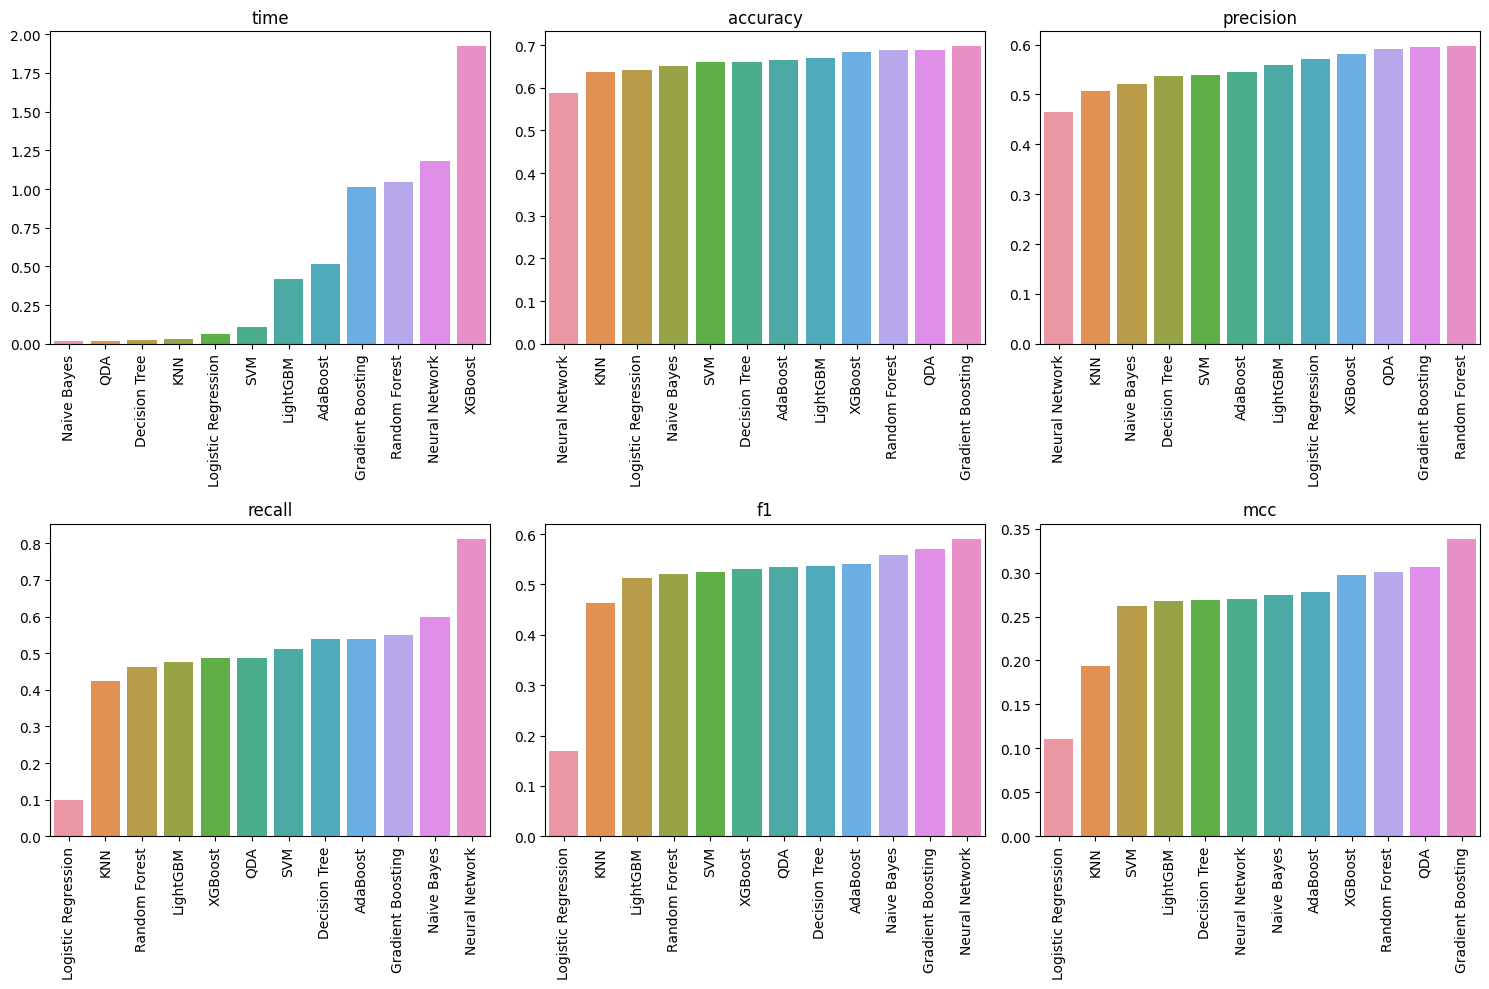

In [23]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# List of metrics
metrics = ['time', 'accuracy', 'precision', 'recall', 'f1', 'mcc']
labels = ['Time', 'Scores', 'Scores', 'Scores', 'Scores', 'Scores']

# Plot each metric
for i, metric in enumerate(metrics):
    row = i // 3 # Integer division to convert i into a row index
    col = i % 3 # Modulo division to convert i into a column index
    ax = axs[row, col]
    df_sorted = df_results.sort_values(metric)  # sort by the current metric
    sns.barplot(data=df_sorted, x='name', y=metric, ax=ax) 
    ax.set_xticklabels(df_sorted['name'], rotation=90)  # set x-tick labels to the names in the sorted DataFrame
    ax.set_title(metric)
    ax.set_xlabel('')  # Remove x-axis title
    ax.set_ylabel('')  # Remove y-axis title

plt.tight_layout()
plt.show()




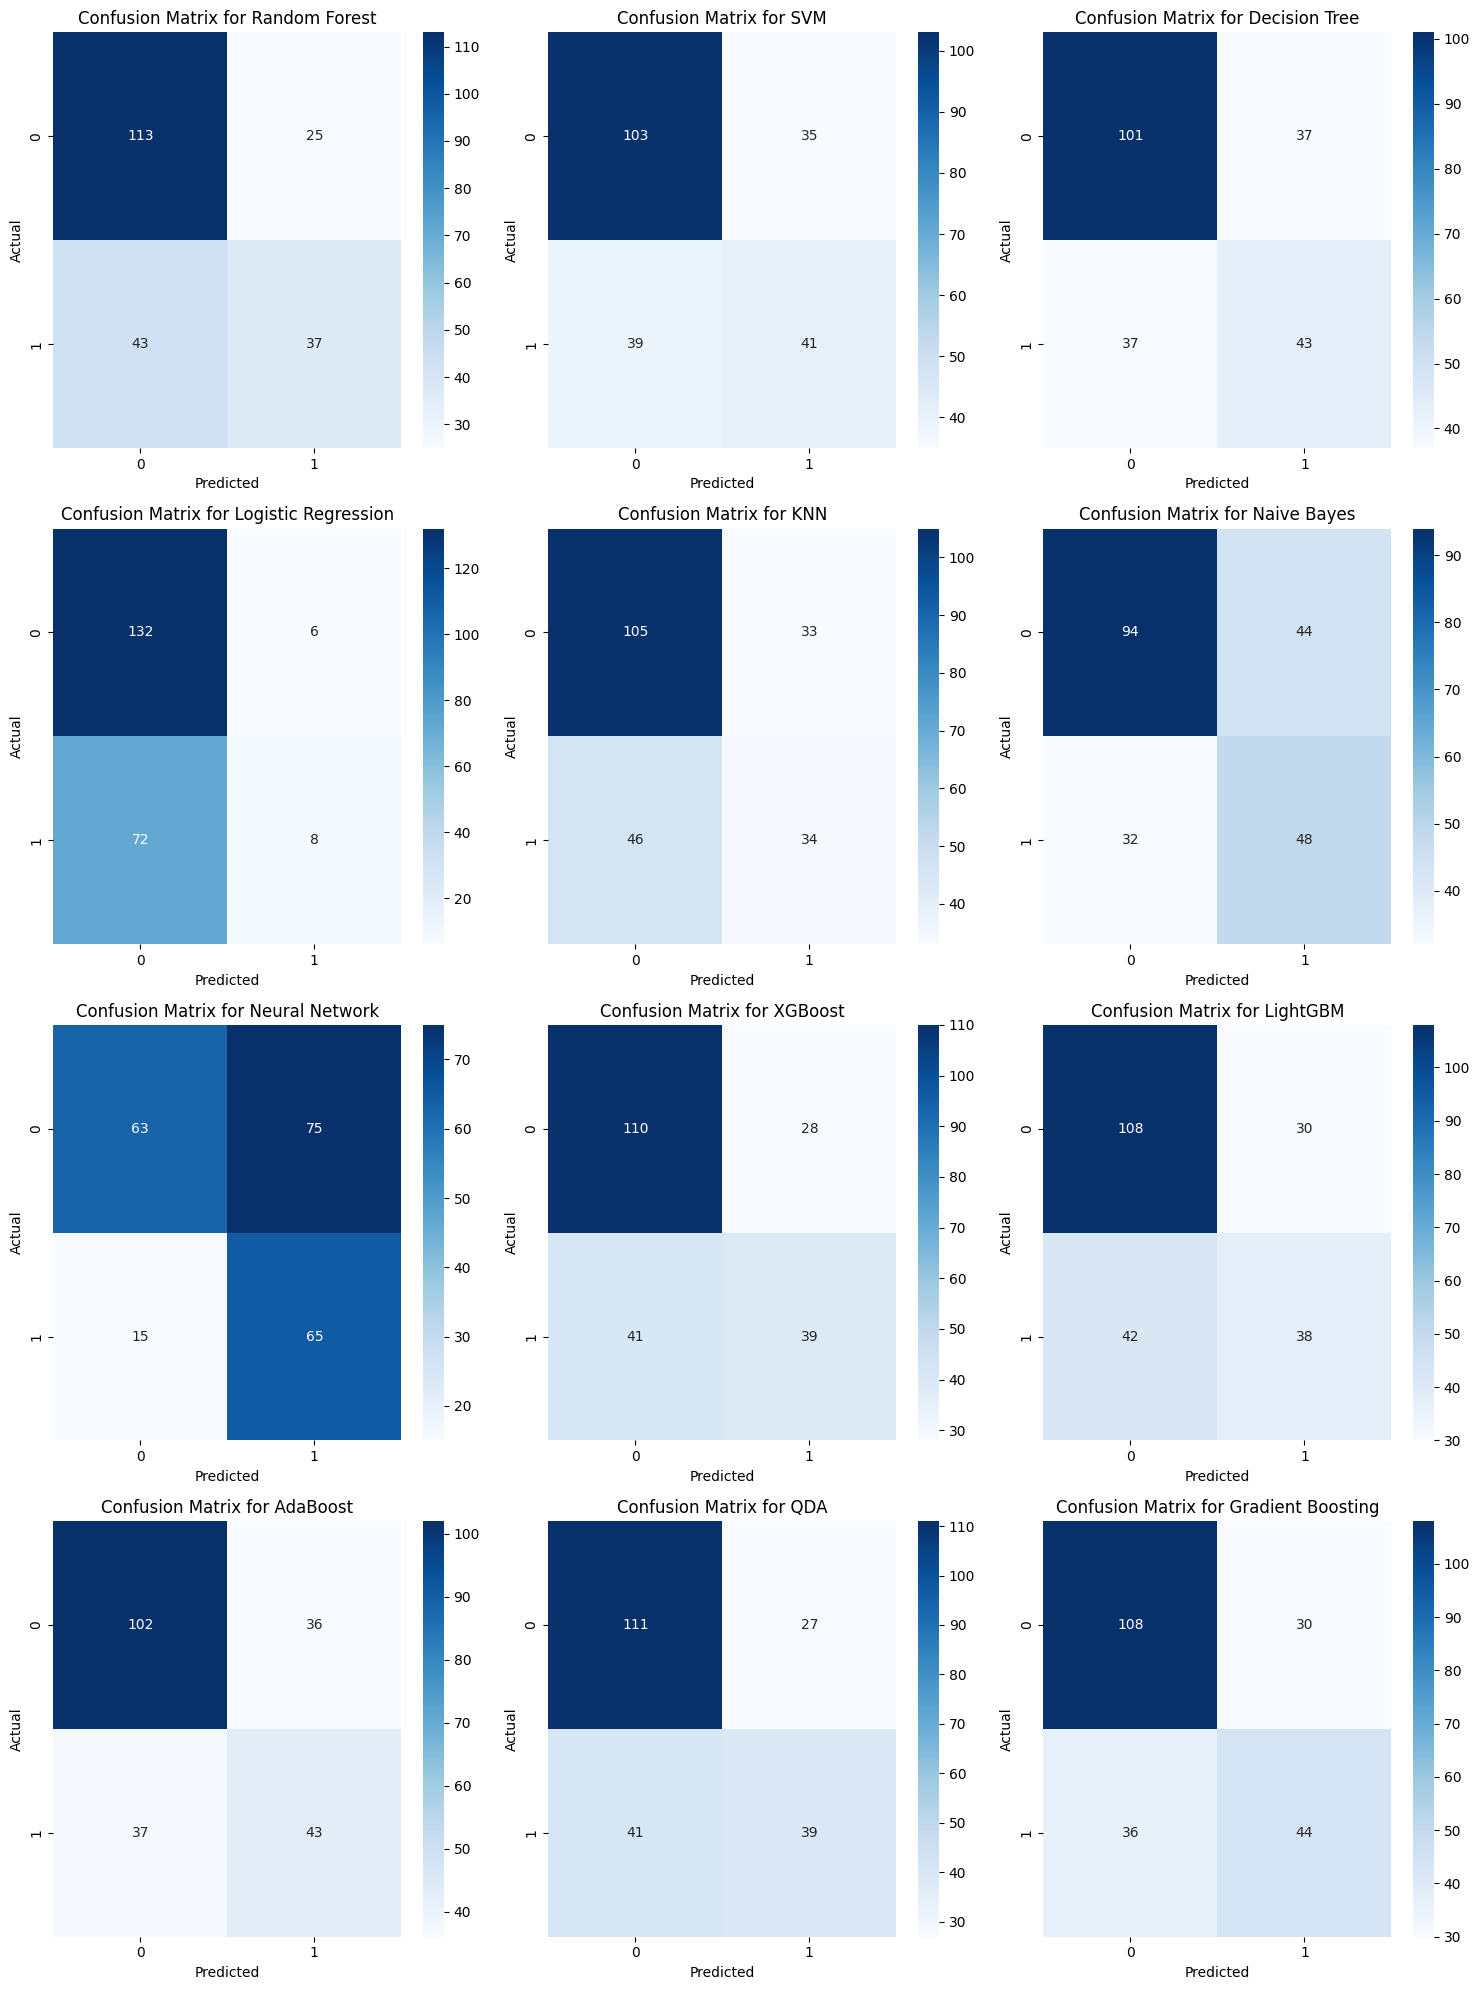

In [24]:
fig, axs = plt.subplots(4, 3, figsize=(15, 20))

# assert subplots matches the number of models
assert len(axs.flatten()) >= len(results)

# Plot the confusion matrix for each model
for i, result in enumerate(results):
    ax = axs.flatten()[i]

    name = result['name']
    cm = result['confusion_matrix']

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix for {name}')

# If there are more subplots than models, hide the extra subplots
for j in range(i+1, len(axs.flatten())):
    axs.flatten()[j].axis('off')

plt.tight_layout()
plt.show()


